In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, fbeta_score
import xgboost as xgb

In [2]:
# Creating a dataframe and displaying first few rows
df = pd.read_csv('/content/drive/MyDrive/2020-Apr.csv', nrows=10000000)
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2020-04-01 00:00:00 UTC,view,1201465,2232732101407408685,apparel.shoes.slipons,samsung,230.38,568984877,e2456cef-2d4f-42b9-a53a-8893cb0c6851
1,2020-04-01 00:00:01 UTC,view,1307156,2053013554658804075,electronics.audio.headphone,apple,1352.67,514955500,38f43134-de83-4710-ae0a-326677d292c6
2,2020-04-01 00:00:01 UTC,view,1480477,2053013563835941749,appliances.kitchen.refrigerators,apple,1184.05,633645770,16aba270-b3c2-4b23-be0a-b7c80bc9da9e
3,2020-04-01 00:00:02 UTC,view,1307050,2053013554658804075,electronics.audio.headphone,apple,1724.34,564933778,05b443bd-e68a-4d72-b971-80bd31109cb8
4,2020-04-01 00:00:03 UTC,view,9500109,2232732104175649385,apparel.scarf,defender,25.05,530206135,e3c1fb4b-0a7e-457d-a0cf-5d1479e9aafc


In [3]:
# Gives us a general summary about the dataFrame's structure and contents
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 686.6+ MB


In [4]:
# Shows the number of customers visiting the site
visitor = df['user_id'].nunique()
print ("No. of Visitors: {}".format(visitor))

No. of Visitors: 1053859


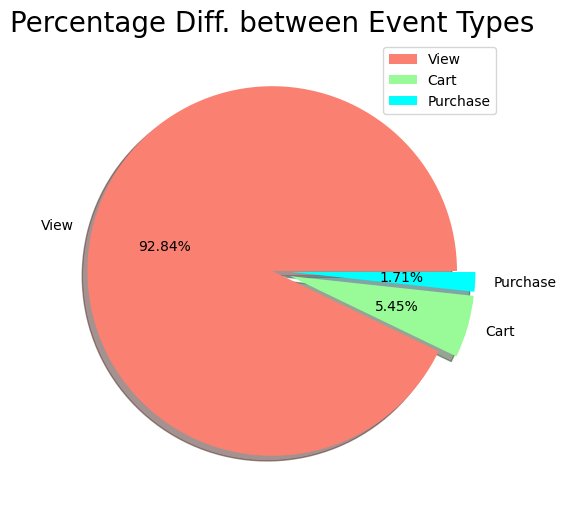

In [5]:
# This chart will tell us the percentage difference between each event type
labels = ['View', 'Cart','Purchase']
size = df['event_type'].value_counts()
colors = ['salmon', 'palegreen','cyan']
explode = [0, 0.1,0.1]

# Plotting the pie chart
plt.rcParams['figure.figsize'] = (6, 6)
plt.pie(size, colors = colors, explode = explode, labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('Percentage Diff. between Event Types', fontsize = 20)
plt.axis('off')
plt.legend()
plt.show()

In [6]:
# This displays first few rows of the items that customers have purchase
pop_purchase = df.loc[df['event_type'] == 'purchase']
pop_purchase = pop_purchase.dropna(axis='rows')
pop_purchase = pop_purchase[["event_type", "product_id", "category_code", "brand", "price"]]
pop_purchase.head()

,event_type,product_id,category_code,brand,price
130,purchase,100177859,construction.tools.drill,s.oliver,60.49
347,purchase,1801503,appliances.personal.massager,xiaomi,203.09
365,purchase,21400996,electronics.clocks,casio,80.42
544,purchase,1307058,electronics.audio.headphone,apple,1415.43
608,purchase,100173008,appliances.kitchen.toster,btwin,221.11


In [7]:
# This shows the amount of items bought for each brand
top_brand = pop_purchase.groupby('brand')['brand'].agg(['count']).sort_values('count', ascending=False)
top_brand.head(20)

,count
brand,
samsung,43903
apple,19992
xiaomi,9296
huawei,6525
oppo,5230
acer,4441
lenovo,3507
asus,3190
hp,2959


In [8]:
# Create label: 1 if user made at least one purchase ('purchase' event_type), 0 otherwise
df['is_purchase'] = (df['event_type'] == 'purchase').astype(int)

# Aggregate user-level features
user_features = df.groupby('user_id').agg(
    event_frequency=('event_type', 'count'),
    unique_products=('product_id', 'nunique'),
    unique_brands=('brand', 'nunique'),
    average_spend=('price', 'mean'),
    total_purchases=('is_purchase', 'sum')
).reset_index()

# Define binary target: whether the user made at least one purchase
user_features['made_purchase'] = (user_features['total_purchases'] > 0).astype(int)
user_features.drop(columns='total_purchases', inplace=True)

# Feature matrix X and target y
X = user_features[['event_frequency', 'unique_products', 'unique_brands', 'average_spend']].fillna(0)
y = user_features['made_purchase']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost classifier
model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("Recall: ", recall_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))
print("fbeta:", fbeta_score(y_test, y_pred, average='weighted', beta=0.5))

Accuracy: 0.9181912208452736
ROC AUC: 0.934230900526159
Recall:  0.4041600462227358
Precision:  0.632936208716634
F1 Score:  0.49331491875055095
fbeta: 0.9074789565980049


In [9]:
# Displays the 10 top users based on total appearances in the dataset where the event_type is either "purchase" or "view"

# Filter for rows where event_type is 'purchase' or 'view'
filtered_df = df[df['event_type'].isin(['purchase', 'view'])]
user_event_counts = filtered_df['user_id'].value_counts().reset_index()
user_event_counts.columns = ['user_id', 'event_count']

# Display top 10 users
top_users = user_event_counts.head(10)
print(top_users)

     user_id  event_count
0  597644399        15064
1  619573377         2345
2  618674364         2194
3  550985043         2061
4  635214021         1811
5  604003957         1751
6  624546549         1587
7  568791020         1550
8  568804062         1437
9  635450036         1428


In [20]:
# Function that recommends products based on purchase history

def recommend_products_for_user(df, user_id, top_n=5):
    # Filter user's recent events
    user_data = df[df['user_id'] == user_id].dropna(subset=['category_code', 'brand'])

    if user_data.empty:
        print("No recent activity found for this user.")
        return pd.DataFrame()

    # Get most recent product categories and brands
    recent_activity = user_data.sort_values('event_time', ascending=False)
    recent_categories = recent_activity['category_code'].values[:3]
    recent_brands = recent_activity['brand'].values[:3]

    # Exclude products already purchased by this user
    purchased_ids = user_data.loc[user_data['event_type'] == 'purchase', 'product_id'].unique()

    # Find candidate products from other users
    candidate_products = df[
        (df['category_code'].isin(recent_categories)) |
        (df['brand'].isin(recent_brands))
    ]

    candidate_products = candidate_products[
        ~candidate_products['product_id'].isin(purchased_ids)
    ]

    # Drop duplicates to avoid showing the same product multiple times
    recommendations = candidate_products[['product_id', 'category_code', 'brand', 'price']].drop_duplicates()

    return recommendations.head(top_n)

# Example
user_id = 568804062
recommendations = recommend_products_for_user(df, user_id)
print(recommendations)

    product_id             category_code    brand    price
5    100068493  construction.tools.light  samsung   319.41
11     1004409  construction.tools.light   doogee    64.09
14     1005105  construction.tools.light    apple  1358.72
15     1004727  construction.tools.light     sony   205.90
22   100082935  construction.tools.light      htc   123.30
